In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.losses import Huber

In [2]:
# open HDF5 file

f1 = h5py.File("./cushion_twophase100x100x50v5.h5", 'r')
f2 = h5py.File("./cushion_twophase100x100x100v0.005.h5", 'r')
f3 = h5py.File("./cushion_twophase200x200x100v0.005.h5", 'r')
f4 = h5py.File("./cushion_twophase200x200x100v0.005.h5", 'r')
f5 = h5py.File("./cushion_twophase200x200x100v0.05.h5", 'r')
f6 = h5py.File("./cushion_twophase200x200x100v5.h5", 'r')
f7 = h5py.File("./cushion_twophase200x200x100v5000.h5", 'r')

f_all = [f1,f2,f3,f4,f5,f6,f7]

template_paths = [
    "Function/CS/{i}", "Function/FS/{i}", "Function/JS/{i}",
    "Function/KF/{i}", "Function/P_S/{i}", "Function/S_S/{i}", 
    "Function/T_S/{i}", "Function/eigS1_CS/{i}", "Function/eigS2_CS/{i}", 
    "Function/eigS3_CS/{i}", "Function/gradp/{i}", "Function/nS/{i}",
    "Function/p/{i}", "Function/rhoFR/{i}", "Function/uS/{i}",
    "Function/wFR/{i}", "Mesh/mesh/geometry", "Mesh/mesh/topology"]

functions = ["Function/CS", "Function/FS", "Function/JS",
"Function/KF", "Function/P_S", "Function/S_S", 
"Function/T_S", "Function/eigS1_CS", "Function/eigS2_CS", 
"Function/eigS3_CS", "Function/gradp", "Function/nS",
"Function/p", "Function/rhoFR", "Function/uS",
"Function/wFR"]

In [13]:
def call_all(f):
    path_all = []
    def read_all(name, obj):
        if not "topology" in name: #filter
            path_all.append(name)
    f.visititems(read_all)
    return path_all

final_results = []

for index, f in enumerate(f_all): #loop f1 to f7
    print(f"\nProcessing file: {f}\nfile: {index+1}")
    path_all = call_all(f) #f1 to f

    file_results = [] #store all f

    # Collect time steps from all files
    time_steps = set()
    for path in path_all:
        if "CS" in path and path.count("/") > 1:
            time_step = path.split('/')[-1] # Extract the time step from the path
            time_steps.add(time_step)  # Add time step to the set      
    time_steps = sorted(time_steps) # Convert the set to a sorted list
    print(f"\nNumber of time steps file: {len(time_steps)}")

    # Loop through each time step
    for time_step in time_steps:
        feature_list = []  # List to hold matrices for the current time step

        # Loop through each function
        for function in functions:
            function_path = f"{function}/{time_step}"
            if function_path in path_all:
                matrix = f[function_path][:] #fi to f
                
            feature_list.append(matrix)
            print(f"path: {function_path}, shape: {matrix.shape}")

        # Horizontally stack matrices for the current time step
        if feature_list:
            stacked_features = np.hstack(feature_list)
            #print(f"path: {function_path}, shape: {stacked_features.shape}")
            file_results.append(stacked_features)

    # Vertically stack the final results
    if file_results:
        file_matrix = np.vstack(file_results)
        #print(f"\nFinal stacked matrix shape: {file_matrix.shape}")
        final_results.append(file_matrix)

# Vertically stack the final results from all files
if final_results:
    final_matrix = np.vstack(final_results)
    x_in = final_matrix
    #print(f"\nFinal stacked matrix shape (x): {x_in.shape}")


Processing file: <HDF5 file "cushion_twophase100x100x50v5.h5" (mode r)>
file: 1

Number of time steps file: 49
path: Function/CS/0_10000000000000001, shape: (1183, 9)
path: Function/FS/0_10000000000000001, shape: (1183, 9)
path: Function/JS/0_10000000000000001, shape: (1183, 1)
path: Function/KF/0_10000000000000001, shape: (1183, 1)
path: Function/P_S/0_10000000000000001, shape: (1183, 9)
path: Function/S_S/0_10000000000000001, shape: (1183, 9)
path: Function/T_S/0_10000000000000001, shape: (1183, 9)
path: Function/eigS1_CS/0_10000000000000001, shape: (1183, 1)
path: Function/eigS2_CS/0_10000000000000001, shape: (1183, 1)
path: Function/eigS3_CS/0_10000000000000001, shape: (1183, 1)
path: Function/gradp/0_10000000000000001, shape: (1183, 3)
path: Function/nS/0_10000000000000001, shape: (1183, 1)
path: Function/p/0_10000000000000001, shape: (1183, 1)
path: Function/rhoFR/0_10000000000000001, shape: (1183, 1)
path: Function/uS/0_10000000000000001, shape: (1183, 3)
path: Function/wFR/0_1

In [15]:
# Call all function
def call_all(f):
    path_all = []
    def read_all(name, obj):
        if not "topology" in name: #filter
            path_all.append(name)
    f.visititems(read_all)
    return path_all

# Collect time steps from all files
time_steps = set()
for f in f_all:
    path_all = call_all(f)
    for path in path_all:
        if "CS" in path and path.count("/") > 1:
            time_step = path.split('/')[-1] # Extract the time step from the path
            time_steps.add(time_step)  # Add time step to the set
        
time_steps = sorted(time_steps) # Convert the set to a sorted list
print(f"Number of time steps: {len(time_steps)}\n")

results = []
input_x = []  # input matrix
output_y = []  # output matrix

#all files
for index, f in enumerate(f_all):
    print(f"File {index+1}:")

    path_all = call_all(f)
    uS_results = []  #"Function/uS/{i}"
    
    for path in path_all:
        if path.count("/") < 2:
            continue

        matrix = f[path][()]

        if "uS" in path:
            uS_results.append(matrix)
            print(f"uS: f{index+1}[\"{path}\"], shape: {np.shape(uS_results)}")
    
    if uS_results:
        uS_matrix = np.vstack(uS_results)
        output_y.append(uS_matrix)     

print(f"\nNumber of uS matrices: {len(uS_results)}")

y_out = np.vstack(output_y)
y = y_out
print(f"final output matrix shape (y): {y.shape}")

Number of time steps: 282

File 1:
uS: f1["Function/uS/0_10000000000000001"], shape: (1, 1183, 3)
uS: f1["Function/uS/0_20000000000000001"], shape: (2, 1183, 3)
uS: f1["Function/uS/0_30000000000000004"], shape: (3, 1183, 3)
uS: f1["Function/uS/0_40000000000000002"], shape: (4, 1183, 3)
uS: f1["Function/uS/0_5"], shape: (5, 1183, 3)
uS: f1["Function/uS/0_59999999999999998"], shape: (6, 1183, 3)
uS: f1["Function/uS/0_69999999999999996"], shape: (7, 1183, 3)
uS: f1["Function/uS/0_79999999999999993"], shape: (8, 1183, 3)
uS: f1["Function/uS/0_89999999999999991"], shape: (9, 1183, 3)
uS: f1["Function/uS/0_99999999999999989"], shape: (10, 1183, 3)
uS: f1["Function/uS/1_0999999999999999"], shape: (11, 1183, 3)
uS: f1["Function/uS/1_2"], shape: (12, 1183, 3)
uS: f1["Function/uS/1_3"], shape: (13, 1183, 3)
uS: f1["Function/uS/1_4000000000000001"], shape: (14, 1183, 3)
uS: f1["Function/uS/1_5000000000000002"], shape: (15, 1183, 3)
uS: f1["Function/uS/1_6000000000000003"], shape: (16, 1183, 3)
uS

In [20]:
#Data Cleaning
#Check for NaN or Inf values in the final matrix
if np.isnan(x_in).any() or np.isinf(x_in).any():
    print("NaN or Inf values in the matrix.")
    x_in = np.nan_to_num(final_matrix, nan=0.0, posinf=0.0, neginf=0.0) #Replace NaN with 0

scalerx = MinMaxScaler()
#Normalize x
x = scalerx.fit_transform(x_in)
print(f"\nFinal normalized matrix shape (x): {x.shape}")


Final normalized matrix shape (x): (529984, 62)


In [21]:
#divide our test array
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.8,random_state=20)

In [25]:
# initialize a object named model from Tensorflow Sequential model class.
model = Sequential()

# 使用 Input 层明确声明输入形状
model.add(Input(shape=(x_train.shape[1],)))  # 显式声明输入层

# 后续层直接添加
#model.add(Dense(16, activation='relu'))  # 隐藏层1
model.add(Dense(64, activation='relu'))  # 隐藏层2
model.add(Dense(16, activation='relu'))  # 隐藏层3

model.add(Dense(3))  # 输出层

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           4,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,123 (20.01 KB)

 Trainable params: 5,123 (20.01 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compile the built model with optimizer, loss and metrics

adam = tf.keras.optimizers.Adam(learning_rate=2e-6)


#adam = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)... for mac users
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

In [33]:
history = model.fit(x_train,y_train,epochs=20,batch_size=64,validation_data=(x_test,y_test))

Epoch 1/20
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 66.5370 - mae: 4.7631 - mse: 66.5370 - val_loss: 5.3123 - val_mae: 1.4620 - val_mse: 5.3123
Epoch 2/20
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 4.4459 - mae: 1.2930 - mse: 4.4459 - val_loss: 3.4313 - val_mae: 1.0133 - val_mse: 3.4313
Epoch 3/20
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2.8633 - mae: 0.9126 - mse: 2.8633 - val_loss: 0.1107 - val_mae: 0.2013 - val_mse: 0.1107
Epoch 4/20
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0750 - mae: 0.1683 - mse: 0.0750 - val_loss: 0.0265 - val_mae: 0.0938 - val_mse: 0.0265
Epoch 5/20
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0220 - mae: 0.0864 - mse: 0.0220 - val_loss: 0.0211 - val_mae: 0.0900 - val_mse: 0.0211
Epoch 6/20
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0109 - mae: 0.0604 - mse: 0.0109 - val_loss: 0.0074 - val_mae: 0.0500 - val_mse: 0.0074
Epoch 7/20
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0068 - mae: 0.0471 - 

In [35]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,33.490696,3.328430,33.490696,5.312281,1.461987,5.312281
1,4.047345,1.182016,4.047345,3.431274,1.013288,3.431274
2,1.903313,0.714400,1.903313,0.110670,0.201290,0.110670
3,0.056075,0.140816,0.056075,0.026475,0.093816,0.026475
4,0.018476,0.077286,0.018476,0.021138,0.089985,0.021138


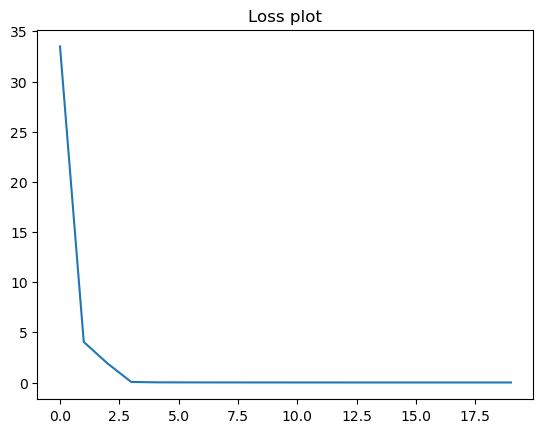

In [37]:
plt.title('Loss plot')
plt.plot(hist['loss'])

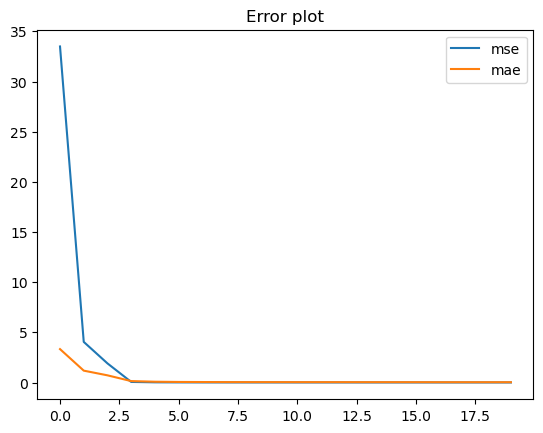

In [39]:
plt.title('Error plot')
plt.plot(hist['mse'], label='mse')
plt.plot(hist['mae'], label='mae')
plt.legend()